# Cross Matching Areas Using Geopandas

### Description of purpose of the script 

This script presents an example for cross matching areas and points with different resolutions. We will be using GeoPandas to import the data and apply spatial intersections. The imported data will be in WGS84 coordinates system, coming from the open sources such as  https://gadm.org/download_country_v3.html. 

We also have some population density numbers from https://www.worldpop.org/geodata/summary?id=37168 which we will use for a small case study. These population values have aggregation accuracy up to 1 KM and they present the number of people per 1$KM^2$ pixel. We will cross match them with the areas and stack the population numbers additively. This will help us to make sort of an assumption for the population for each area.     

Keep in mind, that the main idea behind this script is to present the cross matching tools of Geopandas regarding shapely objects and to present some visualization capabilities of Geopandas, and secondly to analyze population distributions as a use case for the tools.

In fact to understand the true distribution, there is a lot of socio-economical and environmental factors that should be taken into consideration and require further theoretical modeling.  


#### Some additional intros

Using the shapefiles from the GADM databases of the administrative boundaries of Lebanon, the areas of each boundary will be calculated in $KM^2$ for 2 sets of high and low resolutions, and we will generate a contribution matrix(C) of of higher resolution area to the lower ones. 

Where $C[i][j]$ = $i_{th}$ spatial area \% contribution of of higher resolution to $j_{th}$ lower resolution area

So if the maps match exactly, the sum of each row of the matrix should be equal to 1. 

This can be used to apply an assumption for disaggregating information from lower resolution data and distribute it to a higher one, if we assume that area is the main linear weighting factor.    


In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

level_1_dir = "Fixtures/Adm_bounds/gadm36_LBN_1.shp"
level_2_dir = "Fixtures/Adm_bounds/gadm36_LBN_2.shp"
pop_dir = "Fixtures/population/ppp_LBN_2020_1km_Aggregated_UNadj.csv"



### Zones from level 1: This are the ones with the lower resolution

In [2]:
#import shapefile
df_1 = gpd.read_file(level_1_dir)

#Initiate coordinate system of Geopandas to WGS84
df_1.set_crs("epsg:4326")

#convert to cartesian system to estimate areas correctly
df_1 = df_1.to_crs('epsg:3857')

#split Multipolygons into seperate polygons 
df_1 = df_1.explode()

#clean the geometries
df_1['geometry']=df_1.buffer(0)

#Estimate area 
df_1['area_km2'] =  df_1.area/10**6

#sort by area size
df_1.sort_values(by='area_km2',inplace=True,ascending=False)
  

In [3]:
df_1.head()

,,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,area_km2
1,0,LBN,Lebanon,LBN.2_1,Baalbak - Hermel,None,None,Muhafazah,Governorate,None,None,"POLYGON ((4009215.981 4011598.233, 4008967.986...",4167.581672
4,0,LBN,Lebanon,LBN.5_1,Mount Lebanon,Baabda,None,Muhafazah,Governorate,None,None,"POLYGON ((3966528.448 3962938.844, 3966456.259...",2887.933075
3,0,LBN,Lebanon,LBN.4_1,Bekaa,Beqaa|Zahleh,None,Muhafazah,Governorate,None,None,"POLYGON ((3992244.838 3950939.576, 3991986.226...",2031.811827
6,0,LBN,Lebanon,LBN.7_1,North,Tripoli,None,Muhafazah,Governorate,None,None,"POLYGON ((3994109.052 4049712.126, 3994157.462...",1730.586698
5,0,LBN,Lebanon,LBN.6_1,Nabatiyeh,None,None,Muhafazah,Governorate,None,None,"POLYGON ((3965561.521 3928314.115, 3965295.264...",1572.024088


Note that the indeces are double. The reason is that when we applied the df_1.explode(), it splits Mutipolygons in single polygons. 

The df_1.buffer(0), cleans up some the polygons and slightly dialates them to prevent errors in the intersections later. Check:  https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.buffer.html

### Zones from level 2: This are the ones with the higher resolution

They are not commented since it's the same

In [4]:
#import shapefile
df_2 = gpd.read_file(level_2_dir)

#Initiate coordinate system of Geopandas to WGS84
df_2.set_crs("epsg:4326")

#convert to cartesian system to estimate areas correctly
df_2 = df_2.to_crs('epsg:3857')

#split Multipolygons into seperate polygons 
df_2 = df_2.explode()

#clean the geometries
df_2['geometry']=df_2.buffer(0)

#Estimate area
df_2['area_km2'] =  df_2.area/10**6 

#sort by area size
df_2.sort_values(by='area_km2',inplace=True,ascending=False)


In [5]:
df_2.head()

,,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,area_km2
2,0,LBN,Lebanon,LBN.2_1,Baalbak - Hermel,None,LBN.2.1_1,Baalbeck,None,None,Qadaa,District,None,None,"POLYGON ((4009215.981 4011598.233, 4008967.986...",3339.673081
0,2,LBN,Lebanon,LBN.1_1,Akkar,None,LBN.1.1_1,Akkar,None,None,Qadaa,District,None,None,"POLYGON ((4034785.865 4090667.138, 4034756.989...",1166.744787
3,0,LBN,Lebanon,LBN.2_1,Baalbak - Hermel,None,LBN.2.2_1,Hermel,None,None,Qadaa,District,None,None,"POLYGON ((4040132.636 4061989.503, 4040225.210...",827.908591
5,0,LBN,Lebanon,LBN.4_1,Bekaa,None,LBN.4.1_1,Rachiaya,None,None,Qadaa,District,None,None,"POLYGON ((3992244.838 3950939.576, 3991986.226...",791.152414
11,0,LBN,Lebanon,LBN.5_1,Mount Lebanon,None,LBN.5.4_1,Chouf,None,None,Qadaa,District,None,None,"POLYGON ((3966528.448 3962938.844, 3966456.259...",703.962539


### Applying intersection 

Let's start with zone intersections, below you can find a function (interesect_areas ) that takes a Geopandas dataframe and checks for intersections with a passed polygon. We will later visualize the intersections and percentage distributions using visualize_dfs 

In [6]:
def intersect_areas(df_A,polygon):
    
    #generate a Geopandas frame
    inter_df=gpd.GeoDataFrame()

    #Intersect the geoFrame with the specified polygon
    inter_df['geometry'] = df_A.intersection(polygon)
    
    #convert into cartesian coordinates 
    inter_df.set_crs(crs='epsg:3857')
    
    #estimate area of intersected regions and convert to Km2
    inter_df['area_km2'] = inter_df.area/10**6
    
    #return the intersected Geopandas frame
    return inter_df


def visualize_dfs(df_A,df_B,column_value=None,legend_info=None,fig_size=(10,10)):
    """
    Parameters.
    ----------
    
    df_A : Geopandas DataFrame
        This is the benchmark dataframe upon which a comparison is done.
        
    df_B : Geopandas DataFrame
        Some analysis and visualization are applied in this Dataframe and comes
        as a second layer.
        
    column_value : str, optional
        The column string that will be used in df_2 to visualize additional info.
        The default is None.
        
    legend_info : dict, optional
        Geopandas legend plotting argumenst. The default is None.
    
    fig_size: tuple, optional 
        Tuple to select figure size of plot. The default in 10 by 10


    Returns
    -------
    None.

    """
    plt.rcParams["figure.figsize"] = fig_size
    
    ax=df_A.plot(alpha=0.5,color='red',edgecolor='black')
    df_B.plot(ax=ax,
              alpha=0.7,
              column=column_value,
              cmap='Blues_r',
              legend='True',
              legend_kwds=legend_info,
              figsize=fig_size,
              edgecolor='blue')


    plt.show()



Let take the city of Tripoli which is one the 3rd largest section in Lebanon

In [7]:
poly_df = df_1.iloc[3]
poly_df

GID_0                                                      LBN
NAME_0                                                 Lebanon
GID_1                                                  LBN.7_1
NAME_1                                                   North
VARNAME_1                                              Tripoli
NL_NAME_1                                                 None
TYPE_1                                               Muhafazah
ENGTYPE_1                                          Governorate
CC_1                                                      None
HASC_1                                                    None
geometry     POLYGON ((3994109.052165051 4049712.12606076, ...
area_km2                                           1730.586698
Name: (6, 0), dtype: object

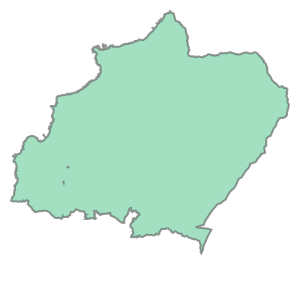

In [8]:
#extract the shape
poly = poly_df.geometry
poly

Let's intersect and visualize

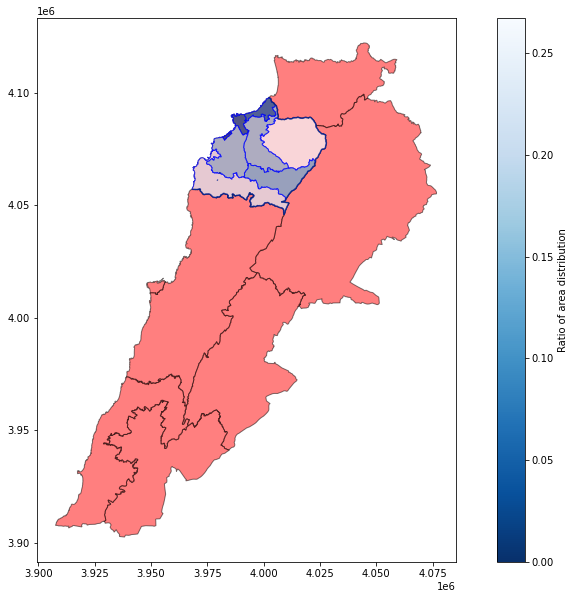

In [9]:
df_example = intersect_areas(df_2,poly)
df_example['area_ratio'] = df_example.area_km2/(poly.area/10**6) 

visualize_dfs(df_1,df_example.iloc[np.where(df_example.geometry)],
                  column_value='area_ratio',
                  legend_info={'label': "Ratio of area distribution",
                               'orientation': "vertical"},fig_size=(15,10))


You can see for the brighter areas are larger and they have a higher percentage contribution to the area

### Let's run it for all the areas

In [10]:
ratios  = np.zeros((len(df_1),len(df_2)))

for index,poly in enumerate(df_1.itertuples()):
    print(f"Count: {index+1}/{len(df_1)}")
    inter_df = intersect_areas(df_2,poly.geometry) 
    inter_df['area_ratio'] = inter_df.area_km2/poly.area_km2
    inter_df['geometry'] = df_2.intersection(poly.geometry)
    inter_df.set_crs(crs='epsg:3857')
    inter_df['area_ratio'] = (inter_df.area/10**6)/poly.area_km2
    ratios[index] = np.array(inter_df.area_ratio)

Count: 1/10
Count: 2/10
Count: 3/10
Count: 4/10
Count: 5/10
Count: 6/10
Count: 7/10
Count: 8/10
Count: 9/10
Count: 10/10


#### Percentages matrix $X[i][j]$
We will now plot the the distribution matrix where the y-axis(rows) is the low resolution and x-axis(columns) is the higher resolution. 

In [11]:
#recalibrate plot sizes
plt.rcParams["figure.figsize"] = (15,10)  

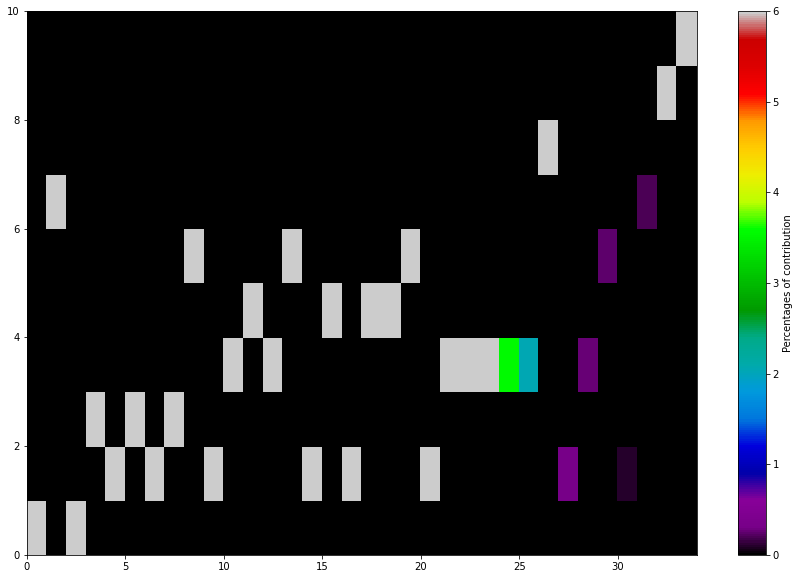

In [12]:
plt.pcolor(100*ratios,cmap='nipy_spectral',vmax=6)
plt.colorbar(label='Percentages of contribution')

### Population data

Now we will import the population data and study the capabilities of the disaggregation

In [13]:
df_pop = pd.read_csv(pop_dir)
df_pop.head()

,X,Y,Z
0,36.336250,34.695417,99.069878
1,36.327917,34.687083,36.110317
2,36.336250,34.687083,22.855825
3,36.344583,34.687083,60.333084
4,36.352917,34.687083,170.474106


In [14]:
df_pop.describe()

,X,Y,Z
count,14729.000000,14729.000000,14729.000000
mean,35.895610,33.927109,463.401589
std,0.338142,0.407595,2996.984243
min,35.102917,33.062083,0.000000
25%,35.644583,33.587083,12.853196
50%,35.886250,33.970417,51.430336
75%,36.161250,34.262083,231.400314
max,36.636250,34.695417,93753.359375


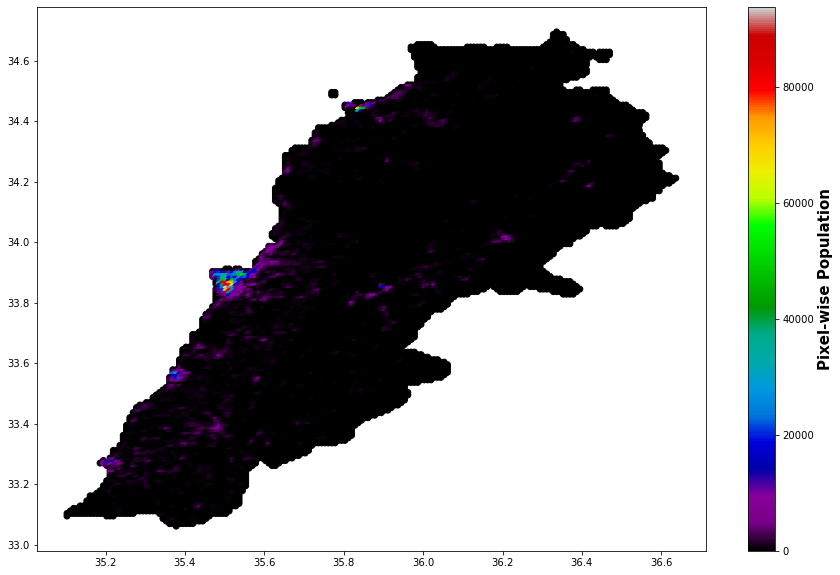

In [15]:
plt.scatter(df_pop.X,df_pop.Y,c=df_pop.Z,cmap='nipy_spectral')
cb = plt.colorbar()
cb.set_label(label='Pixel-wise Population',weight='bold',fontsize=15)
plt.show()


## Study case: Analyzing population values

#### Importing the population data

In [16]:
#Initiate geodataframe for population
gdf_pop = gpd.GeoDataFrame(geometry=[Point(i) for i in zip(df_pop.X,df_pop.Y)],  crs="epsg:4326")

#convert to cartesian system to estimate areas correctly
gdf_pop = gdf_pop.to_crs('epsg:3857')

#add population values
gdf_pop['population'] = df_pop.Z


#### Cross matching points with the low resolution area

In [17]:
df_1_pop = np.zeros(df_1.shape[0])
for index,pop_loc in enumerate(gdf_pop.itertuples()):
    if index%2000 == 0 : print(f"Count: {index}/{len(gdf_pop)}")
    temp = df_1.contains(pop_loc.geometry)
    temp = np.array(temp.astype(int))*np.array(pop_loc.population)
    df_1_pop = df_1_pop + temp 

Count: 0/14729
Count: 2000/14729
Count: 4000/14729
Count: 6000/14729
Count: 8000/14729
Count: 10000/14729
Count: 12000/14729
Count: 14000/14729


#### Visualizing the cross_matching

In [18]:
df_1_pop


array([ 371194.91311301, 3143532.36446346,  355783.16723273,
        773381.97042675,  513832.10308675,  850196.51528919,
        130483.74376053,  585438.60842133,       0.        ,
             0.        ])

In [19]:
df_1_pop.sum() # 6.8 million in 2020 which is close

6723843.385793751

In [20]:
df_1['population'] = df_1_pop

<AxesSubplot:>

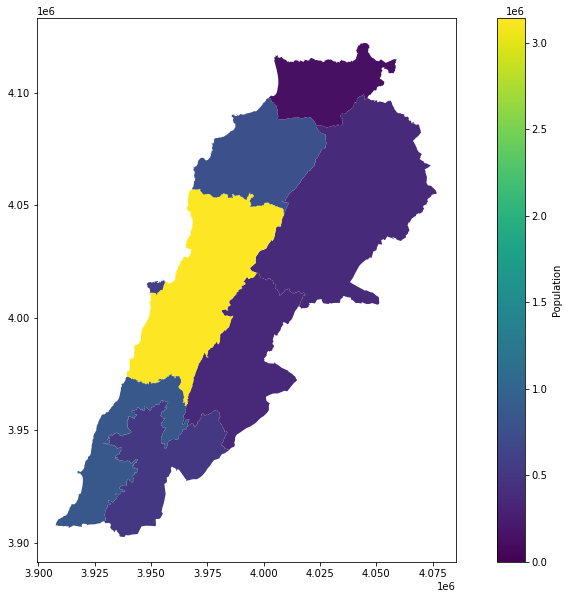

In [21]:
df_1.plot(column='population',legend=True,legend_kwds={'label': "Population",
                               'orientation': "vertical"})

In [22]:
df_1.sort_values(by='population',ascending=False)

GID_0   NAME_0    GID_1            NAME_1     VARNAME_1 NL_NAME_1  \
4 0   LBN  Lebanon  LBN.5_1     Mount Lebanon        Baabda      None   
7 0   LBN  Lebanon  LBN.8_1             South         Sidon      None   
6 0   LBN  Lebanon  LBN.7_1             North       Tripoli      None   
2 0   LBN  Lebanon  LBN.3_1            Beirut          None      None   
5 0   LBN  Lebanon  LBN.6_1         Nabatiyeh          None      None   
1 0   LBN  Lebanon  LBN.2_1  Baalbak - Hermel          None      None   
3 0   LBN  Lebanon  LBN.4_1             Bekaa  Beqaa|Zahleh      None   
0 2   LBN  Lebanon  LBN.1_1             Akkar          None      None   
  1   LBN  Lebanon  LBN.1_1             Akkar          None      None   
  0   LBN  Lebanon  LBN.1_1             Akkar          None      None   

        TYPE_1    ENGTYPE_1  CC_1 HASC_1  \
4 0  Muhafazah  Governorate  None   None   
7 0  Muhafazah  Governorate  None   None   
6 0  Muhafazah  Governorate  None   None   
2 0  Muhafazah  Governorate  None   None   
5 0  Muhafazah  Governorate  None   None   
1 0  Muhafazah  Governorate  None   None   
3 0  Muhafazah  Governorate  None   None   
0 2  Muhafazah  Governorate  None   None   
  1  Muhafazah  Governorate  None   None   
  0  Muhafazah  Governorate  None   None   

                                              geometry     area_km2  \
4 0  POLYGON ((3966528.448 3962938.844, 3966456.259...  2887.933075   
7 0  POLYGON ((3956506.705 3942009.665, 3956481.226...  1316.948214   
6 0  POLYGON ((3994109.052 4049712.126, 3994157.462...  1730.586698   
2 0  POLYGON ((3953928.654 4012060.081, 3953895.532...    30.910353   
5 0  POLYGON ((3965561.521 3928314.115, 3965295.264...  1572.024088   
1 0  POLYGON ((4009215.981 4011598.233, 4008967.986...  4167.581672   
3 0  POLYGON ((3992244.838 3950939.576, 3991986.226...  2031.811827   
0 2  POLYGON ((4034345.929 4088623.712, 4034505.172...  1168.982386   
  1  POLYGON ((3980570.780 4064226.452, 3980539.357...     0.015608   
  0  POLYGON ((3979487.498 4061024.267, 3979466.690...     0.003515   

       population  
4 0  3.143532e+06  
7 0  8.501965e+05  
6 0  7.733820e+05  
2 0  5.854386e+05  
5 0  5.138321e+05  
1 0  3.711949e+05  
3 0  3.557832e+05  
0 2  1.304837e+05  
  1  0.000000e+00  
  0  0.000000e+00

#### Cross matching with the high resolution data

In [23]:
df_2_pop = np.zeros(df_2.shape[0])
for index,pop_loc in enumerate(gdf_pop.itertuples()):
    if index%2000 == 0 : print(f"Count: {index}/{len(gdf_pop)}")
    temp = df_2.contains(pop_loc.geometry)
    temp = np.array(temp.astype(int))*np.array(pop_loc.population)
    df_2_pop = df_2_pop + temp 

Count: 0/14729
Count: 2000/14729
Count: 4000/14729
Count: 6000/14729
Count: 8000/14729
Count: 10000/14729
Count: 12000/14729
Count: 14000/14729


In [24]:
df_2_pop

array([3.31975291e+05, 1.29843118e+05, 3.92196219e+04, 4.16538489e+04,
       3.12792220e+05, 2.66497739e+05, 5.12136609e+04, 4.76315791e+04,
       3.53958195e+05, 2.12322958e+05, 9.97414516e+04, 3.14302660e+05,
       1.16539132e+05, 4.14031085e+05, 7.98558053e+05, 6.84637486e+04,
       2.76337976e+05, 3.16379477e+04, 9.94277465e+04, 8.09173284e+04,
       1.49108539e+06, 7.79336858e+04, 6.36418972e+04, 3.04413285e+04,
       1.05854809e+05, 2.74760076e+05, 5.85438608e+05, 1.52955214e+02,
       4.46958954e+03, 1.28990729e+03, 1.06915210e+03, 6.40625393e+02,
       0.00000000e+00, 0.00000000e+00])

In [25]:
df_2_pop.sum() # 6.8 million in 2020 which is close

6723843.385793751

In [26]:
pop_loc

Pandas(Index=14728, geometry=<shapely.geometry.point.Point object at 0x7f990a796310>, population=14.819263458251951)

In [27]:
df_2['population'] = df_2_pop

<AxesSubplot:>

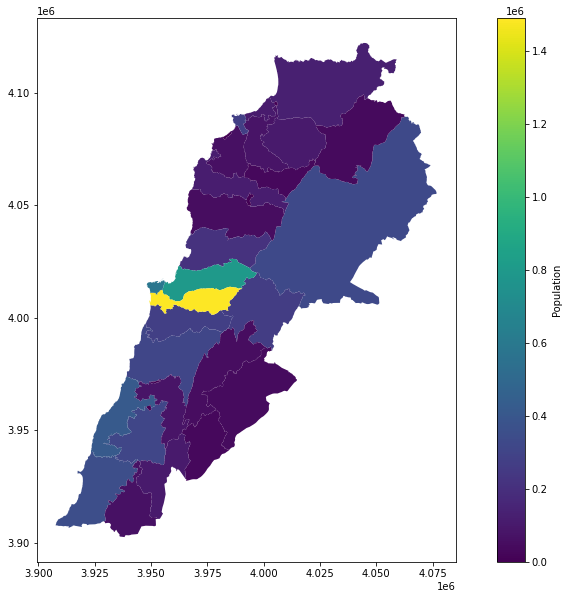

In [28]:
df_2.plot(column='population',legend=True,legend_kwds={'label': "Population",
                               'orientation': "vertical"})

### Generate theoretical distribution of population

In this section we will use the low resolution population distribution to generate a higher resolution distribution using area weights. Then we will compare the theoretical to the observed one.  

In [29]:
#copy the high resolution dataframe and drop the population column
df_2_theo = df_2.copy()
df_2_theo.drop('population',axis=1,inplace=True)

In [30]:
df_2_theo.sample(5) #visualize 5 random rows

,,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,area_km2
5,0,LBN,Lebanon,LBN.4_1,Bekaa,None,LBN.4.1_1,Rachiaya,None,None,Qadaa,District,None,None,"POLYGON ((3992244.838 3950939.576, 3991986.226...",791.152414
12,0,LBN,Lebanon,LBN.5_1,Mount Lebanon,None,LBN.5.5_1,El Metn,None,None,Qadaa,District,None,None,"POLYGON ((3989406.476 4013135.755, 3989308.807...",386.036901
25,0,LBN,Lebanon,LBN.7_1,North,None,LBN.7.6_1,Zgharta,None,None,Qadaa,District,None,None,"POLYGON ((4006509.686 4065018.788, 4006412.866...",268.099514
21,0,LBN,Lebanon,LBN.7_1,North,None,LBN.7.2_1,Bcharre,None,None,Qadaa,District,None,None,"POLYGON ((4012819.562 4056475.054, 4012791.960...",234.197270
6,0,LBN,Lebanon,LBN.4_1,Bekaa,None,LBN.4.2_1,West Bekaa,None,None,Qadaa,District,None,None,"POLYGON ((3971784.769 3955039.399, 3971801.330...",607.101112


### Dot product of ratio and population

By applying the dot product of the ratios that we estimates using the cross section of the areas and 

In [31]:
df_2_theo['population'] = np.dot(ratios.T,np.array(df_1.population))

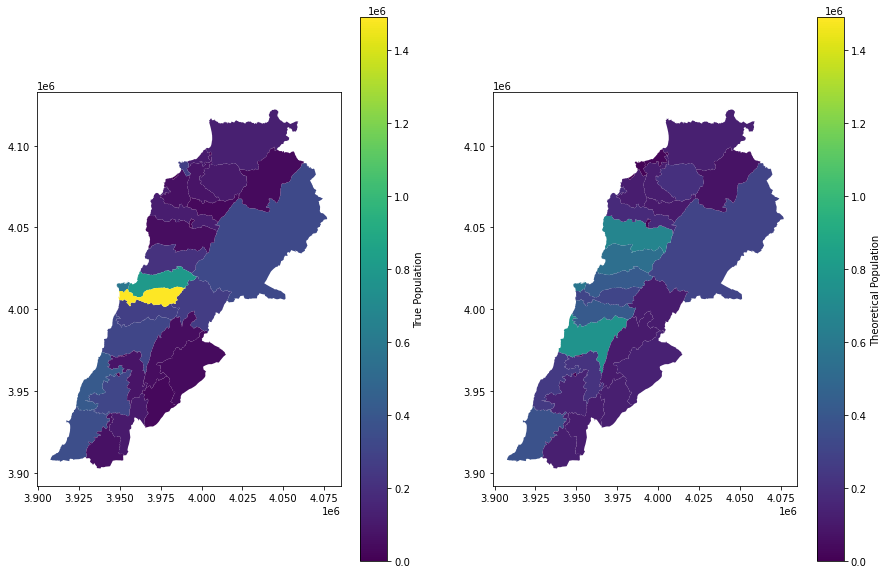

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,10))

df_2.plot(ax=axes[0],column='population',legend=True,legend_kwds={'label': "True Population"})
df_2_theo.plot(ax=axes[1],column='population',legend=True,vmax=df_2.population.max(),legend_kwds={'label': "Theoretical Population"})
plt.show()



#### Let's see the area differences in % error 

<AxesSubplot:>

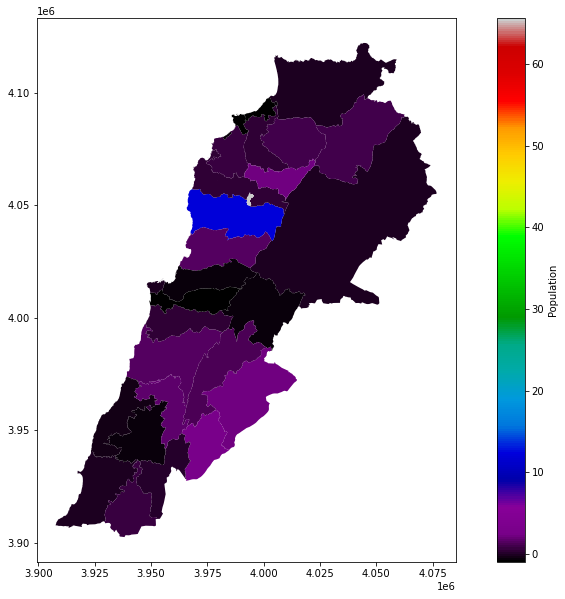

In [33]:
diff = df_2.copy().drop("population",axis=1)
diff['population'] = (df_2_theo.population - df_2.population)/ (df_2.population)
diff.plot(column='population',legend=True,legend_kwds={'label': "Population",
                               'orientation': "vertical"},cmap='nipy_spectral')

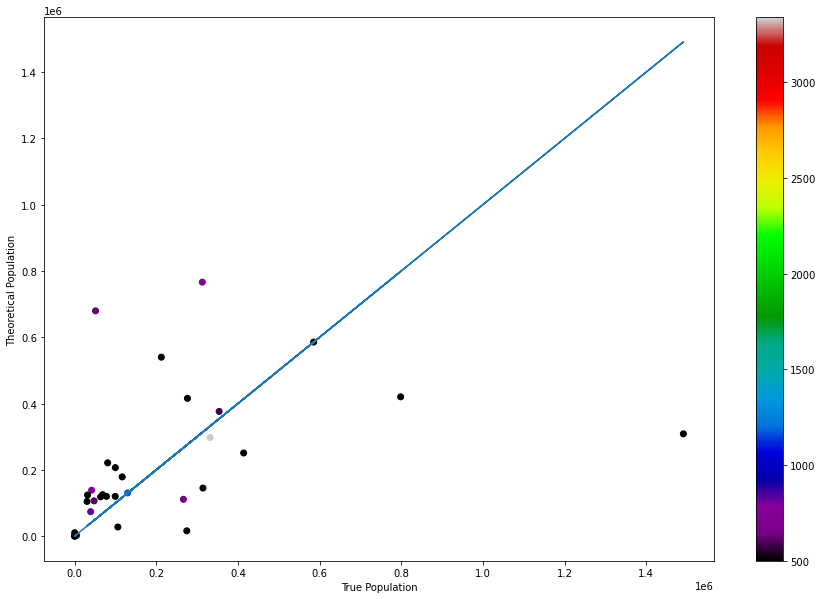

In [35]:
plt.figure(figsize=(15,10))
plt.scatter(df_2.population,df_2_theo.population,c=df_2.area_km2,cmap='nipy_spectral',vmin=500)
plt.plot(df_2.population,df_2.population)
plt.xlabel("True Population")
plt.ylabel("Theoretical Population")
plt.colorbar()
plt.show()


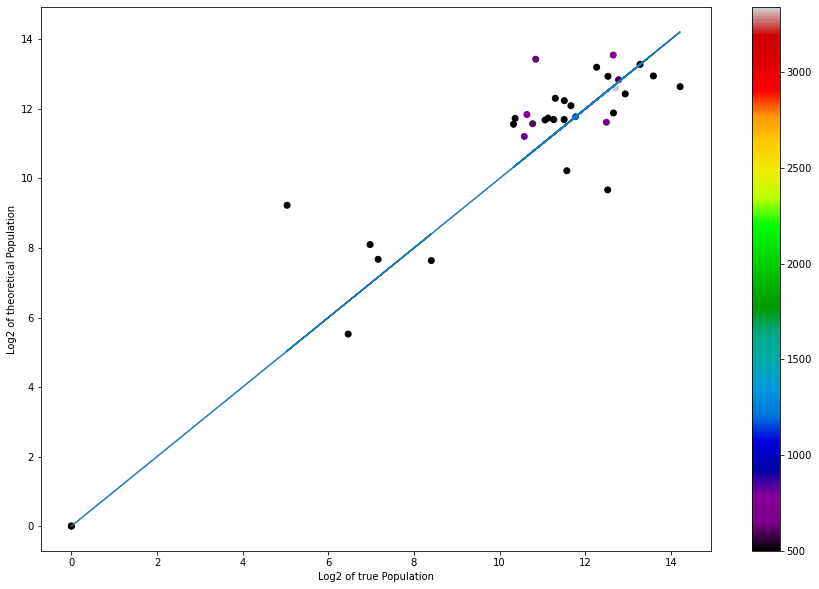

In [36]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.scatter(np.log(df_2.population+1),np.log(df_2_theo.population+1),c=df_2.area_km2,cmap='nipy_spectral',vmin=500)
plt.plot(np.log(df_2.population+1),np.log(df_2.population+1))
plt.xlabel("Log2 of true Population")
plt.ylabel("Log2 of theoretical Population")
plt.colorbar()
plt.show()

### Conclusions

In this work, we have analyzed the areas between the high and the low resolution administrative boundaries of Lebanon and saw that GeoPandas is a handy tool in applying the intersections both between Polygons and Points. 

The open source data helped us to present a study case about the populations numbers of Lebanon, and the analysis has showed that although area is one of factors we can see that the region of Mount Lebanon near the capital of Beirut shows the most inconsistencies and differences due to the high number of population and it's attractiveness. It is interesting also to notice that the residuals on a linear scale shows a heteroskedastic behaviour whereas on the log scale it is less in that nature, 